In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

In [138]:
k = 2    # base (i.e. binary)
l = 4    # no. inputs

In [139]:
def bool_func(func_number, x):    # x number between 0 and 7 indicating the inputs of zeros and ones in binary for the 3 input boolean function.
    return (func_number & (1 << x)) >> x

def hamming_pair(x, y):
    # Determines if two numbers are edge connected in Hamming graph of their binary representations.
    z = x ^ y
    return z and not(z & (z-1))

def LZC(input_str):
    # Function to find the LZ complexity of a string.
    keys_dict = {}
    ind = 0
    inc = 1
    while True:
        if ind+inc > len(input_str):
            break
        sub_str = input_str[ind:ind + inc]
        if sub_str in keys_dict:
            inc += 1
        else:
            keys_dict[sub_str] = 0
            ind += inc
            inc = 1
    len1 = len(keys_dict)
    
    input_str_rev = input_str[::-1]
    keys_dict = {}
    ind = 0
    inc = 1
    while True:
        if ind+inc > len(input_str_rev):
            break
        sub_str = input_str_rev[ind:ind + inc]
        if sub_str in keys_dict:
            inc += 1
        else:
            keys_dict[sub_str] = 0
            ind += inc
            inc = 1
    len2 = len(keys_dict)
    
    return np.log2(l)*(len1+len2)/2

In [141]:
# This code plots the robustness of neutral components agains the frequenc
freq = []
rho = []
LZ = []

for func_number in tqdm(range(0, k**(k**l), 1)):
    
    NS = {}      # Defines neutral set
    G_N0 = {}    # Defines neutral set graphs for output 0
    G_N1 = {}    # Defines neutral set graphs for output 1
    NC0 = {}     # Defines neutral components of neutral set 0
    NC1 = {}     # Defines neutral components of neutral set 1
    
    for i in range(k**l):
        NS[i] = bool_func(func_number, i)
    
    count = 0                      # We use the same counter for both neutral sets as all that matters is that neutral components have the same value
    for i in NS:
        if NS[i] == 0:             # Begin by sorting the out the neutral components of sequences with output 0
            com_ind = []           # Keep track of common indices for new binary sequence to check whether disjoint neutral components now join.
            for key in NC0:
                if hamming_pair(i, key):
                    com_ind.append(NC0[key])
                else:
                    pass
            if len(com_ind)>0:
                NC0[i] = min(com_ind)
                for key in NC0:
                    if NC0[key] in com_ind:
                        NC0[key] = min(com_ind)
            else:
                NC0[i] = count
                count += 1
        else:                       # This sorts through the neutral components of sequences with output 1
            com_ind = []
            for key in NC1:
                if hamming_pair(i, key):
                    com_ind.append(NC1([key]))
                else:
                    pass
                if len(com_ind)>0:
                    NC1[i] = min(com_ind)
                    for key in NC1:
                        if NC1[key] in com_ind:
                            NC1[key] = min(com_ind)
                else:
                    NC1[i] = count
                    count += 1
    
    
    ind0 = sorted(set(NC0.values()))
    ind1 = sorted(set(NC1.values()))
    
    for val in ind0:
        G_N0[val] = [0,0]
        for key_i in NC0:
            if NC0[key_i] == val:
                G_N0[val][0] += 1
                for key_j in NC0:
                    if NC0[key_j] == val and key_j > key_i:
                        G_N0[val][1] = G_N0[val][1] + hamming_pair(key_i, key_j)
                    else:
                        pass
            else:
                pass
    
    for val in ind1:
        G_N1[val] = [0,0]
        for key_i in NC1:
            if NC1[key_i] == val:
                G_N1[val][0] += 1
                for key_j in NC1:
                    if NC1[key_j] == val and key_j > key_i:
                        G_N1[val][1] = G_N1[val][1] + hamming_pair(key_i, key_j)
                    else:
                        pass
            else:
                pass  
            
    bin_func_num = format(func_number, '0'+str(k**l)+'b')
    complexity = LZC(bin_func_num)
    
    for key in G_N0:
        rho0 = (2*float(G_N0[key][1]))/(l*(k-1)*float(G_N0[key][0]))
        rho.append(rho0)
        freq0 = G_N0[key][0]
        freq.append(freq0)
        LZ.append(complexity)
    for key in G_N1:
        rho1 = (2*float(G_N1[key][1]))/(l*(k-1)*float(G_N1[key][0]))
        rho.append(rho1)
        freq1 = G_N1[key][0]
        freq.append(freq1)
        LZ.append(complexity)

100%|███████████████████████████████████████████████████████████████████████████████████████| 65536/65536 [00:14<00:00, 4642.14it/s]


In [142]:
freq_np = np.array(freq)
freq_log2 = np.log2(freq_np/(k**l))

logF_cont = pd.read_csv('n_'+str(l)+'/logF_continuous.txt', header=None)
rho_blancmange = pd.read_csv('n_'+str(l)+'/rho_blancmange.txt', header=None)
rho_1comp_min = pd.read_csv('n_'+str(l)+'/rho_1comp_min.txt', header=None)
rho_lower = pd.read_csv('n_'+str(l)+'/rho_lower.txt', header=None)
rho_upper = pd.read_csv('n_'+str(l)+'/rho_upper.txt', header=None)
rho_null = pd.read_csv('n_'+str(l)+'/rho_null.txt', header=None)

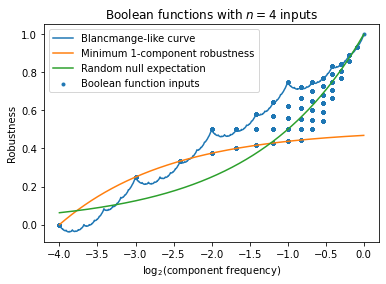

In [149]:
plt.plot(logF_cont, rho_blancmange, label='Blancmange-like curve')
plt.plot(logF_cont, rho_1comp_min, label='Minimum 1-component robustness')
plt.plot(logF_cont, rho_null, label='Random null expectation')
plt.scatter(freq_log2, rho, marker='.', label='Boolean function inputs')
plt.title('Boolean functions with $n=4$ inputs')
plt.xlabel('log$_2$(component frequency)')
plt.ylabel('Robustness')
plt.legend()
plt.savefig('n_4_freq.png')
plt.show()

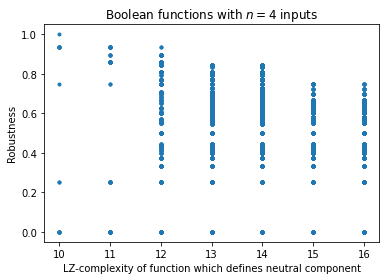

In [150]:
plt.scatter(LZ, rho, marker='.')
plt.title('Boolean functions with $n=4$ inputs')
plt.xlabel('LZ-complexity of function which defines neutral component')
plt.ylabel('Robustness')
plt.savefig('n_4_LZ.png')
plt.show()

In [117]:
LZC('1010')

{'0': 0, '1': 0, '01': 0}


6.0

In [118]:
np.log2(6)

2.584962500721156